# Deep Learning Models for AF Detection from ECG Signals

<strong> Atrial fibrillation </strong> (AF) is the most common <strong> cardiac arrhythmia</strong>, a heart condition characterized
by uncoordinated electrical pulses in the heart. These pulses can be read through <strong>ECG</strong>
readings and a medical professional can diagnose AF by analyzing the ECG data. However,
the intermittent nature of atrial fibrillation makes it challenging to detect AF in short ECG
readings.

• Our goal is to develop a machine learning model that can accurately diagnose AF despite its
intermittent and random symptoms

• Our model also must overcome the challenge of noisy ECG signals

Imports the necessary libraris for the classical CNN (mostly torch) and for the quantum CNN (pennylane libraries)

In [12]:
#-------------------------- OS & Waveform Libraries ----------------------------------------------------------

import pandas as pd
import scipy.io
import csv
import wfdb
import os
import shutil
import time
import random


#---------------------------CNN Libraries---------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Adam

#---------------------------Quantum Libraries---------------------------------------------------------

import pennylane as qml
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding, BasisEmbedding, SqueezingEmbedding, DisplacementEmbedding, IQPEmbedding
from math import ceil
import pickle
import traceback

#---------------------------Hyper-parameter Tuniung Libraries---------------------------------------------------------

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

#--------------------------- Quantum PreProcessing/Embedding Libraries---------------------------------------------------------

from scipy.fft import fft, fftshift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn.manifold import SpectralEmbedding
from lpproj import LocalityPreservingProjection 

# 1. Sorting the Data
 We were given ECG Data in the form of .mat files with their respective header files (.hea) in one large folder, along with a referenece table in the form of a (.csv) file. Our first goal was to sort these data files to allow us ot be able to easily create a database in which we could train our Deep Learning Models. 
 
 This first cell declares the paths to each folder.

In [7]:
#/path/to/your/respective/directory

# Determines path to orgin as well as each destination  
folder_A = '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data/Class_A'
folder_N = '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data/Class_N'
folder_O = '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data/Class_O'
source_dir = '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data'
ref_dir = '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/References'

This for loop cycles through the data in the source directory and reads, plots, and sorts the data into their respective folders according to the "Reference.csv" file. Our data consisted of 8,528 .mat files 59% of which were ECG signals from patients with a normal heartbeat and 9% of which is from patients diagnosed with AF, and the rest unclassfied. 

<strong> NOTICE: If running on Mac or PC with a small amount RAM or CPU cores this next cell will need to be run in a small number of cycles in the for loop. Try increments of 500 instead of all 8,528 at once can otherwise this can cause program or computer to crash. </strong>

In [8]:
# Total number of files is 8528
for i in range(0, 8528):
    #Declares file name in each cycle 
    file_name = f'A{i+1:05d}' 
    
    #Path to Header and Data files
    data_path = os.path.join(source_dir, file_name)
    
    try:
        
        
        #Reads header file 
        header = wfdb.rdheader(data_path)
        print(f"Header of file: {file_name}:")
        print(header)
        
        #Reads data file 
        record = wfdb.rdrecord(data_path)
        print(f"Signal Data of file: {file_name}:")
        print(record)
        
        #Extracts the signal data
        for idx, signal in enumerate(record.p_signal.T):
            print(f"\nSignal data for {file_name}:")
            print(signal)
        
        #Plots the signal data on graph 
        wfdb.plot_wfdb(record=record, title = f'Signal Data for {file_name}')
            
        
        #Scans through csv file data 
        
        #Finds path to reference file and scans thru new line in reference file 
        with open (os.path.join(ref_dir, 'REFERENCE.csv'), newline = '') as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                file_id, category = row
                
                #Checks if the current file read corresponds to the classifaication being read
                if file_id == file_name:
                
                    #Determines destination based on category
                    if category == 'N':
                        target_dir = folder_N
                    elif category == 'A':
                        target_dir = folder_A
                    else:
                        target_dir = folder_O
                    
                    # Source and destination paths
                    source_path_mat = os.path.join(source_dir, f'{file_name}.mat')
                    dest_path_mat = os.path.join(target_dir, f'{file_name}.mat')
                    source_path_hea = os.path.join(source_dir, f'{file_name}.hea')
                    dest_path_hea = os.path.join(target_dir, f'{file_name}.hea')
                    
                    # Moves the .mat and .hea file to the target directory
                    if os.path.exists(source_path_mat):
                        shutil.move(source_path_mat, dest_path_mat)
                        shutil.move(source_path_hea, dest_path_hea)
                        print(f"Moved from {source_path_mat} to {dest_path_mat}")
                    else:
                        print(f"File in {source_path_mat} not found. Skipping.")

        
    # Allows program to continue if the expected file is not in the original specified location   
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")
        continue
        

File A00001 not found. Skipping.
File A00002 not found. Skipping.
File A00003 not found. Skipping.
File A00004 not found. Skipping.
File A00005 not found. Skipping.
File A00006 not found. Skipping.
File A00007 not found. Skipping.
File A00008 not found. Skipping.
File A00009 not found. Skipping.
File A00010 not found. Skipping.


# 2. Creating DataFrame

Our next step was to load the sorted data files into our program in a format the CNN could process.

This first cell defines the functions for the creationn of the dataframe. 

In [9]:
#--------------------------Read and Combine Funtions----------------------------------------------------------

def read_mat_files(folder_path, label):
    data_list = [] 
    label_list = []

    #Loads all the mat files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".mat"):
            file_path = os.path.join(folder_path, filename)
            mat_data = scipy.io.loadmat(file_path)
            
            data_list.append(mat_data)
            label_list.append(label)

    return data_list, label_list

def combine_data(folder_paths):
    all_data = []
    all_labels = []
    signals_array = []

    #
    for label, folder_path in enumerate(folder_paths):
        data_list, labels = read_mat_files(folder_path, label)
        all_data.extend(data_list)
        all_labels.extend(labels)

        # Process each .mat file in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".mat"):
                file_path = os.path.join(folder_path, filename)
                record = wfdb.rdrecord(file_path.replace(".mat", ""))
                
                for idx, signal in enumerate(record.p_signal.T):
                    signals_array.append(signal)

    # Convert to DataFrame
    dataFrame = pd.DataFrame(signals_array)
    labelSeries = pd.Series(all_labels, name='label')

    return dataFrame, labelSeries
    
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In this block we create the dataframe by calling the previous functions and save the dataframe as a .csv file for easy reference for any other programs working with this data. 

Since folder O contains unclassified data and we want to create a binary classifier we only use the data from folders A and N. Of the data we are actually using in our model 88% is from patients with a normal heartbeat, and 12% from those diagnosed with AF.

In [10]:
#---------------------------------Defining Database Structure---------------------------------------------------

# Determines path to each class folder
folder_paths = [
    '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data/Class_A',
    '/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Data/Class_N'  #Removed Folder O since we want binary classification
]

# Combine data
dataFrame, labelSeries = combine_data(folder_paths)
 
# Verify that DataFrame and Series are created properly
print(f"DataFrame shape: {dataFrame.shape}")
print(f"Label Series shape: {labelSeries.shape}")

# Combine DataFrame and Series
dataFrame = pd.concat([labelSeries, dataFrame], axis=1)

# Randomize the rows in the DataFrame
dataFrame = dataFrame.sample(frac=1, random_state=43).reset_index(drop=True)

# Verify the combined DataFrame
print(f"Combined and randomized DataFrame shape: {dataFrame.shape}")

# Save to CSV
try:
    dataFrame.to_csv('combined_ECG_Data.csv', index=False)
    print("CSV file created successfully.")
except Exception as e:
    print(f"Error saving CSV file: {e}")


DataFrame shape: (5788, 18286)
Label Series shape: (5788,)
Combined and randomized DataFrame shape: (5788, 18287)
CSV file created successfully.


# 3. Create and Train the Convolutional Neural Network

First step is to designate the training and testing sets as well as the length of ECG signal to analyze. We also randomize the the dataframe rows to help distribute the amount of normal data and AF data between the training and testing sets.

In [13]:
#---------------------------------Designating Training and Testing Sets--------------------------------------------

# --- Train and Test split manually (total # of recordings is 5788) ---
# --- Dataset: Previously sectioned ECG recordings into 2-second (360 Hz) windows ---

train = dataFrame.iloc[0:4000] 
test = dataFrame.iloc[4001:]

sub_timewindow = 960

# Print the shape of train to understand its dimensions
print("Shape of train DataFrame:", train.shape)

X_train = train.iloc[:, 0:sub_timewindow].values  # voltages, train
X_test = test.iloc[:, 0:sub_timewindow].values    # voltages, test
Y_train = train['label'].values      # results, train
Y_test = test['label'].values        # results, test

print('Train Shape - voltages, label:')
print(X_train.shape, Y_train.shape)
print('Test Shape - voltages, label:')
print(X_test.shape, Y_test.shape)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# ---------------------------------- Create training and validation sets -----------------------------------------

# Set a seed value
seed = 43
set_seed(seed)

# Split the training set into training and validation
val_split = 0.2
train_size = int((1 - val_split) * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_tensor, Y_train_tensor), [train_size, val_size])

# DataLoaders for training, validation, and test setsr
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)


Shape of train DataFrame: (4000, 18287)
Train Shape - voltages, label:
(4000, 960) (4000,)
Test Shape - voltages, label:
(1787, 960) (1787,)


In this next block we define our CNN model. 1D Convolutional Neural Networks are good at learning and extracting import features from the data set so we let the model determine the parameters and patterns ot look for without telling it what to look for.  

In [14]:
#---------------------------------Defining Model---------------------------------------------------

# Define the model architecture in PyTorch
class ECGModel(nn.Module):
    def __init__(self, num_filters, kernel_size, dropout_rate): # Allows for inout of hyperparameter changes
        super(ECGModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(3)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=kernel_size)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Equivalent to GlobalAveragePooling1D
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(num_filters*4, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), 1, -1)  # Reshape to (batch_size, channels, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.global_avg_pool(x).squeeze(-1)
        x = torch.sigmoid(self.fc(x))
        return x

Below we optimize the hyperparameters of our model to help improve the results. We also declare the device to run on and ensure that Apple Silicon Macs are able to use GPU acceleration as well as PCs. If running on Apple Silicon Mac check out the PyTorch documentation to ensure that your version of PyTorch required for GPU acceleration (PyTorch Preview(Nightly)). 

https://pytorch.org/get-started/locally/

In [15]:
#---------------------------------Define Space---------------------------------------------------

space = [
    Integer(8, 128, name='num_filters'),
    Integer(3, 7, name='kernel_size'),
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Real(0.1, 0.5, name='dropout_rate'),
    Integer(8, 128, name='batch_size')
]

#---------------------------------Determining Hyperparameters---------------------------------------------------

# Define the objective function
@use_named_args(space)
def objective(**params):
    num_filters = params['num_filters']
    kernel_size = params['kernel_size']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']

    # Print parameters for debugging
    print(f'Params: {params}')

    # Check if batch_size is valid
    if not isinstance(batch_size, int) or batch_size <= 0:
        return -1e10

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = ECGModel(num_filters, kernel_size, dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.squeeze().cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    auroc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)

    # Check for large values
    if np.isnan(auroc) or np.isnan(auprc) or np.isinf(auroc) or np.isinf(auprc):
        return -1e10  # Assign a large negative value if nan or inf is encountered
    print('AUROC: ', auroc)
    print('AUPRC: ', auprc)
    # Return the negative value since we want to maximize these scores
    return -(auroc + auprc)

# Device configuration

# Check for MPS availability 
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Perform Bayesian Optimization
res = gp_minimize(objective, space, n_calls=50, random_state=42)

Params: {'num_filters': 104, 'kernel_size': 4, 'learning_rate': 0.0021830968390524623, 'dropout_rate': 0.33874006317859484, 'batch_size': 61}
Params: {'num_filters': 20, 'kernel_size': 5, 'learning_rate': 0.00010025956902289566, 'dropout_rate': 0.15714672716877634, 'batch_size': 86}
Params: {'num_filters': 15, 'kernel_size': 6, 'learning_rate': 0.006541210527692739, 'dropout_rate': 0.10031150633640573, 'batch_size': 127}
Params: {'num_filters': 82, 'kernel_size': 5, 'learning_rate': 1.0500232504231345e-05, 'dropout_rate': 0.10922497001656631, 'batch_size': 71}
Params: {'num_filters': 56, 'kernel_size': 3, 'learning_rate': 0.008341930294140789, 'dropout_rate': 0.19310853617212173, 'batch_size': 19}
Params: {'num_filters': 82, 'kernel_size': 5, 'learning_rate': 0.008906204386161689, 'dropout_rate': 0.286705157299192, 'batch_size': 111}
Params: {'num_filters': 90, 'kernel_size': 5, 'learning_rate': 1.0959604536925834e-05, 'dropout_rate': 0.4768807022739412, 'batch_size': 76}
Params: {'num

The cell cycles thru the data according to teh specified number of "epochs" training the data each time. It is desiged to stop early of the "learning rate" is below a certain threshold after the specified time "patience". The validation phase records the learning loss in each iteration. 

In [16]:
#---------------------------------Training and Validation Loop---------------------------------------------------
# Best parameters
best_params = res.x
print(f'Best parameters: {best_params}')

# Use the best parameters to retrain the model on the entire training set
num_filters = best_params[0]
kernel_size = best_params[1]
learning_rate = best_params[2]
dropout_rate = best_params[3]
batch_size = int(best_params[4])

# Create data loaders with the best batch size
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)


# Model instance
model = ECGModel(num_filters, kernel_size, dropout_rate).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Epochs was 100
epochs = 100
patience = 30 # Number of ecpoch program will wait for before stopping
best_val_loss = float('inf')
epochs_of_no_improve = 0
early_stop = False 

# Check for MPS availability 
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Determine whether or not to implement an Early Stop
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        early_stop = True
        break

 # Message to show how many epochs were completed before stopping   
if not early_stop:
    print(f'Training completed after {epochs} epochs')


Best parameters: [104, 4, 0.0021830968390524623, 0.33874006317859484, 61]
ECGModel(
  (conv1): Conv1d(1, 104, kernel_size=(4,), stride=(1,))
  (conv2): Conv1d(104, 208, kernel_size=(4,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(208, 416, kernel_size=(4,), stride=(1,))
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.33874006317859484, inplace=False)
  (fc): Linear(in_features=416, out_features=1, bias=True)
)
Epoch 1/100, Training Loss: 0.3938, Validation Loss: 0.3778
Epoch 2/100, Training Loss: 0.3829, Validation Loss: 0.3883
Epoch 3/100, Training Loss: 0.3865, Validation Loss: 0.3741
Epoch 4/100, Training Loss: 0.3836, Validation Loss: 0.3687
Epoch 5/100, Training Loss: 0.3841, Validation Loss: 0.3718
Epoch 6/100, Training Loss: 0.3819, Validation Loss: 0.3700
Epoch 7/100, Training Loss: 0.3833, Validation Loss: 0.3654
Epoch 8/100, Training Loss: 0.3821, Validation Loss: 0.3675
Ep

Plots Trainging and Validation loss. The commented out areas are annotations that can be manually adjusted to show Underfitting and Overfitting regions as well as the region that is an exact fit (transition from Underfit to Overfit range) 

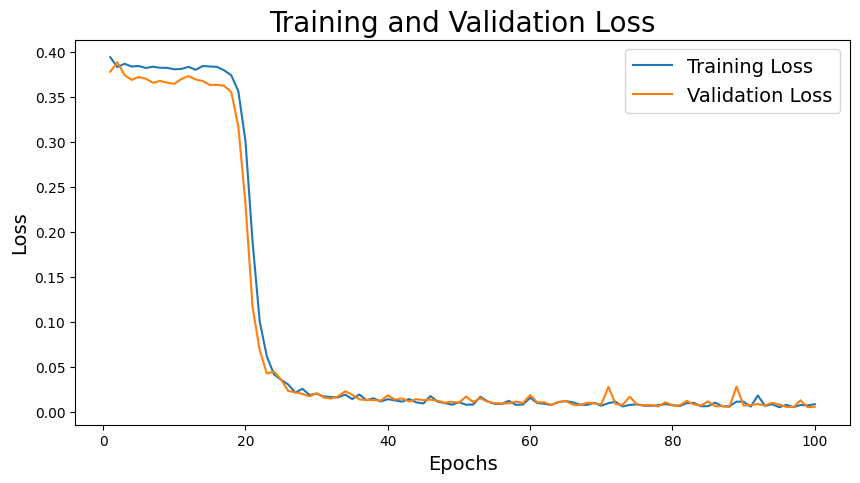

In [17]:
# ---------------------------------- Plot Training and Validation Loss ----------------------------------

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
#plt.axvline(x=40, color='r', linestyle='--', alpha=0.5)

"""
plt.annotate('Underfitting',
             fontsize=16,
             color='red',
             xy=(5, 0.3),        # Point to annotate
             xytext=(10, 0.4),   # Text location
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('Overfitting',
             fontsize=16,
             color='red',
             xy=(85, 0.15),      
             xytext=(75, 0.3), 
             arrowprops=dict(facecolor='red', shrink=0.05))
             
             """

plt.title('Training and Validation Loss', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()



Shows the evaluaiton on the testing set using metrics such as Accuracy, Precision, Recall, F1 Score, AUROC, and AUPRC. This cell of code also calculates and displays the Confusion Matrix for the models performance on the test set. 

• Accuracy = NumOfCorrectPred / TotalPred

• Precision = TruPos / TotalPos

• Recall = TruPos/ (TruPos + FalseNeg)

• F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

• AUROC = Area Under Reciever Operator Curve

• AUPRC = Area Under Precsion Recall Curve


In [18]:
# ------------------------------------- Evaluation on Test Set -------------------------------------

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)

# Saves the performance scores to file in performance folder
with open('/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Performance/CNN_Performance_Scores.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Accuracy','Precision', 'Recall' ,'F1 Score' , 'AUROC' , 'AUPRC', 'Confusion Matrix'])
    writer.writerow([accuracy, precision, recall , f1 , auroc , auprc,  confusion_matrix(y_true, y_pred_binary)])

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')

Confusion Matrix:
[[ 226    3]
 [   4 1554]]
Accuracy: 0.9961
Precision: 0.9981
Recall: 0.9974
F1 Score: 0.9978
AUROC: 0.9999
AUPRC: 1.0000


# 4. Define Components of the Quantum Convolutional Neural Network


After creating the database the first time in the previous code run this cell to load in the database if bypassing teh previous CNN code. 

In [19]:
#---------------------------------------Load Database---------------------------------------------

dataFrame = pd.read_csv('/Users/mateo/combined_ECG_Data.csv')

# Verify the combined DataFrame
print(f"Combined and randomized DataFrame shape: {dataFrame.shape}")

#-------------------------Designating Training and Testing Sets--------------------------------------

# --- Dataset: Previously sectioned ECG recordings into 2-second (360 Hz) windows ---

sub_timewindow = 360

x, y = dataFrame.iloc[:, 0:sub_timewindow].values, dataFrame['label'].values

print('x-shape: ')
print(x.shape)
print('y-shape: ')
print(y.shape)


Combined and randomized DataFrame shape: (5788, 18287)
x-shape: 
(5788, 360)
y-shape: 
(5788,)


### Define Preprocessing Techniques

In order to reduce the dimensionality of the data, we choose a preprocessing technique (PCA or a classical autoencoder) and apply it to the dataset. This allows us to have a smaller quntum circuit of an appropriate amounbt of wires (ex. 8) instead of all 360 features (360 wires). This can help the quantum circuit to focus on the more important features (exclude noise and inconsistant patterns) in the data and reduce the computational complexity. 

In [20]:
#--------------------------------- Defining PreProcessing Techniques that Reduce Dimensionality of Data ---------------------------------------------------

# defines classical data preprocessing techniques
def pca(x, c):
    pca = PCA(n_components=c)
    x = pca.fit_transform(x)
    return x

def autoencoder(x, c, verbose=False):
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, encoding_dim):
            super(Autoencoder, self).__init__()

            # Encoding layer
            self.encoder = nn.Linear(input_dim, encoding_dim)

            # Decoding layer
            self.decoder = nn.Linear(encoding_dim, input_dim)

        def forward(self, x):
            x = torch.relu(self.encoder(x))
            x = torch.sigmoid(self.decoder(x))
            return x

    input_dim = x.shape[1]  # Number of features in the input

    # Create the model
    model = Autoencoder(input_dim, c)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of epochs
    num_epochs = 1000

    # Train the model
    x = torch.from_numpy(x).float()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, x)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch:{epoch + 1}, Loss:{loss.item()}')

    # Use the encoder to produce the encoded array
    encoded_x = model.encoder(x).data

    return encoded_x

def undersampling(x, c):
    indices = np.linspace(0, x.shape[1]-1, c).astype(int)
    x_undersampled = x[:, indices]
    
    assert x_undersampled.shape == (x.shape[0], c), x_undersampled.shape

    return x_undersampled

def laplacian_eigenmaps(x, c):
    embedding = SpectralEmbedding(n_components=c)
    x = embedding.fit_transform(x)
    return x

def locality_preserving_projections(x, c):
    embedding = LocalityPreservingProjection(n_components=c)
    x = embedding.fit_transform(x)
    return x

def compressive_sensing_fft(x, c):
    x_fft = fftshift(fft(x)) # compute the centered Fourier transform
    Xr = (10/8) * x_fft * np.random.permutation(np.repeat([0,0,1,1,1,1,1,1,1,1], x.shape[1]/10) ) # 10/8 is the scaling factor to make sure the amplitude is preserved
    Xr_no_zeros = [row[row.nonzero()] for row in Xr]
    Xr_2d = np.vstack(Xr_no_zeros)
    return Xr_2d

def compressive_sensing(x, c):
    phi = np.random.randn(256, 320)
    y = np.dot(phi, x.T)
    return y.T


### Define Encoding Methods

Quantum circuits can't process calssical data directly. It must be encodiged into a quantum state for it to be processed by a quantum computer. There are multiple techniques for this process. Some of the ones wed use below are <strong> Angle Embedding, Amplitude Embedding, </strong> and  <strong>Flexible Representaion of Quantum Images Encoding. </strong>

In [21]:
def FRQI(datapoints, wires):
    for wire in wires[:-1]:
        qml.Hadamard(wires=wire)
    controls = [i for i in range(len(wires) - 1)] # num_qubits-1

    for pos in range(len(datapoints)):
        bin = format(pos, '08b')
        clist = []
        for i in bin:
            clist.append(int(i))
        # set up the x's corresponding to the clist
        for i in range(len(clist)):
            if clist[i] == 0:
                qml.PauliX(controls[i])

        # apply the controlled phase gate
        qml.ctrl(qml.RY(phi=2*datapoints[pos], wires=wires[-1]), control=controls)

        # undo the x's
        for i in range(len(clist)):
            if clist[i] == 0:
                qml.PauliX(controls[i])


### Defining Quantum Convolutional Layer Architectures

These are some quantum convolutional layer architectures which consist of different combinations of gates. These gates span across one or two wires in a quantum circuit and mimic the learning and feature extraction capabilities of a classical convolutional layer.  

In [22]:
def conv1(params, wires):
    qml.RZ(-np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(np.pi/2, wires=wires[0])

def conv2(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[0])
    qml.RZ(params[2], wires=wires[0])
    qml.RX(params[3], wires=wires[1])
    qml.RY(params[4], wires=wires[1])
    qml.RZ(params[5], wires=wires[1])
    qml.IsingZZ(params[6], wires=[wires[0], wires[1]])
    qml.IsingYY(params[7], wires=[wires[0], wires[1]])
    qml.IsingXX(params[8], wires=[wires[0], wires[1]])
    qml.RX(params[9], wires=wires[0])
    qml.RY(params[10], wires=wires[0])
    qml.RZ(params[11], wires=wires[0])
    qml.RX(params[12], wires=wires[1])
    qml.RY(params[13], wires=wires[1])
    qml.RZ(params[14], wires=wires[1])

def conv3(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def conv4(params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

def conv5(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def conv6(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

def conv7(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

def conv8(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

def conv9(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

def conv10(params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

def conv11(params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

### Defining Pooling Layer Architectures

These are some quantum pooling layer architectures which also consist of different combinations of gates. These gates span across one or two wires in a quantum circuit and mimic the properties of a classical pooling layer by reducing the dimensionality of the input data through a series of of quantum gates. 

In [23]:
# taken from https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html
def pool1(params, wires):
    qml.RZ(-np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[1])

# taken from https://www.tensorflow.org/quantum/tutorials/qcnn
def pool2(params, wires):
    qml.RX(params[0], wires=wires[1])
    qml.RY(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[1])
    qml.RX(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[0])
    qml.RZ(params[5], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(-params[6], wires=wires[1])
    qml.RY(-params[7], wires=wires[1])
    qml.RX(-params[8], wires=wires[1])

# taken from https://arxiv.org/abs/2108.00661
def pool3(params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

# inspired by https://www.nature.com/articles/s41567-019-0648-8
def pool4(params, wires):
    measurement = qml.measure(wires=wires[0])
    qml.cond(measurement==0, qml.RZ)(params[0], wires=wires[1])



# Testing QCNN Configurations 

<strong>QCNN Construction/Training/Testing Workflow</strong>

What we have done in the previous cell blocks

1. Define Preprocess Data
2. Define Encoding Methods
3. Define Convlolutional Layer Architecture
4. Define Pooling Layer Architecture

What this next cell block will do...

5. Cycle through the different consigurations we have defined previously (Preprocess Methods, Encoding Methods, Convolutional Layers, Pooling Layers) 

In [26]:
#--------------------------------- Choose PreProcessing Techniques ---------------------------------------------------
#Initializes metrics chart 
with open('/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Performance/QCNN_Performance_Scores.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Preprocessing Method','Num of Features', 'Encoding Method', 'Convolutional Layer Architecture', 'Num of Params', 'Pooling Architecture', 'Num of Params', 'Convs per Layer', 'Special Pooling', 'Pooling Direction','Accuracy','Precision', 'Recall' ,'F1 Score' , 'AUROC' , 'AUPRC', 'Confusion Matrix'])

for i in range(6):
    j = 8

    #'Please select the classical data preprocessing technique: \n 1. PCA \n 2. Autoencoder \n 3. Undersampling \n 4. Laplacian Eigenmaps \n 5. Locality Preserving Projections \n 6. Compressive sensing with FFT \n 7. Compressive sensing \n Selection is: ')
    selection = i+1
    if selection == 1:
        c = 8
        num_of_features = c
        x = pca(x, c)
    elif selection == 2:
        c = 8
        num_of_features = c
        x = autoencoder(x, c)
    elif selection == 3:
        c = j
        x = undersampling(x, c)
    elif selection == 4:
        c = j
        x = laplacian_eigenmaps(x, c)
    elif selection == 5:
        c = j
        x = locality_preserving_projections(x, c)
    elif selection == 6:
        c = j
        x = compressive_sensing_fft(x, c)
    elif selection == 7:
        c = j
        x = compressive_sensing(x, c)
    print("Shape of data: ", x.shape)
    

    #--------------------------------- Choose Encoding Method ---------------------------------------------------
    for i in range(2):
        try:   
            #input('Please select the quantum feature map: \n 1. Angle Embedding \n 2. Amplitude Embedding \n 3. FRQI \n Selection is: ')
            encode_selection = i+1
            if encode_selection == 1:
                n_qubits = x.shape[1]
                embedding = AngleEmbedding
            elif encode_selection == 2:
                n_qubits = int(np.log2(x.shape[1]))
                x = normalize(x)
                embedding = AmplitudeEmbedding
            elif encode_selection == 3:
                n_qubits = 9
                x = normalize(x)
                embedding = FRQI

            # train test split
            split = 0.8*x.shape[0]
            train_x, train_y = x[:int(split), :], y[:int(split)]
            test_x, test_y = x[int(split):, :], y[int(split):]
        except Exception as e:
            print(f'Error during execution: {e}')
            traceback.print_exc()
            continue # Skips the PreProcessing technique
        
        #--------------------------------- Choosing Convolutional Layer Architectures ---------------------------------------------------

        params_per_conv_layer_map = {
            1: 3,
            2: 15,
            3: 2,
            4: 2,
            5: 4,
            6: 6,
            7: 6,
            8: 6,
            9: 10,
            10: 10,
            11: 15
        }
        for i in range(10):
            try:
                #input("Select the convolutional layer you want to use (1-11): ")
                conv_selection = f"{i+1}"
                conv = globals()[f"conv{conv_selection}"]
                params_per_conv = params_per_conv_layer_map[int(conv_selection)]
                conv_selection = i+1
                print(params_per_conv)
            except Exception as e:
                print(f'Error during execution: {e}')
                traceback.print_exc()
                continue # Skips the PreProcessing technique

            #--------------------------------- Choosing Pooling Layer Architectures ---------------------------------------------------

            params_per_pool_layer_map = {
                1: 3,
                2: 9,
                3: 2,
                4: 1
            }
            for i in range(3):
                try:

                    #input("Select the pooling layer you want to use (1-4): ")
                    pooling_selection = f"{i+1}"
                    pool = globals()[f"pool{pooling_selection}"]
                    params_per_pool = params_per_pool_layer_map[int(pooling_selection)]
                    pooling_selection = i+1

                    #--------------------------------- Construct QCNN ---------------------------------------------------

                    # set up the quantum device
                    dev = qml.device('default.qubit', wires = n_qubits)

                    #Applies standard pooling operation between pairs of qubits
                    def pooling_layer(sources, sinks, params):
                        param_index = 0
                        for source, sink in zip(sources, sinks):
                            pool(params[param_index:param_index+params_per_pool], wires=[source, sink])
                            param_index += params_per_pool

                    inv_mapping = {
                        1:4,
                        2:2,
                        4:1,
                    }

                    #Applies alternative pooling layer which applies a conditional rotaion. 
                    def pooling_layer_other(sources, sinks, params):
                        measurements = [np.nan for i in range(8)]
                        for i in sources:
                            measurements[i] = qml.measure(wires=i)
                        print(f"sources: {sources} | sinks: {sinks} | measurements: {measurements}")
                        if len(sources) > 1:
                            for count, j in enumerate(sinks):
                                qml.cond(measurements[j-inv_mapping[len(sources)]] == 1, qml.RZ)(params[count], wires=j)
                                qml.cond(measurements[j+inv_mapping[len(sources)]] == 1, qml.RZ)(params[count], wires=j)
                        else:
                            qml.cond(measurements[4] == 1, qml.RZ)(params[0], wires=sinks[0])

                    def conv_layer(wires, params, convs_per_layer):
                        param_index = 0

                        for i in range(convs_per_layer):
                            for q1, q2 in zip(wires[::2], wires[1::2]):
                                conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
                                param_index += params_per_conv
                            for q1, q2 in zip(wires[1::2], wires[2::2] + [min(wires)]):
                                conv(params[param_index:param_index+params_per_conv], wires=[q1, q2])
                                param_index += params_per_conv

                        
                except Exception as e:
                    print(f'Error during execution: {e}')
                    traceback.print_exc()
                    continue # Skips the PreProcessing technique

                for i in range(2):
                    try:

                        #int(input("Select the number of covolutions per layer you want to use (1-3): "))

                        convs_per_layer = i+1

                        assert convs_per_layer in [1, 2, 3], "You must select 1, 2, or 3 convolutions per layer"

                        #----------------------------------------------------------------------------------------------------------------------
                        for i in range(1):
                            try: 
                                special_pooling = bool(int(i))
                                
                                if special_pooling:
                                    specialPooling = 'Yes'
                                    poolingDirection = 'None'
                                    pooling_direction = 2
                                    params_per_pool = 1

                                for i in range(1):
                                    try:
                                        if not special_pooling:
                                            
                                                specialPooling = 'No'
                                                if i == 0:
                                                    poolingDirection = 'Top half'
                                                else:
                                                    poolingDirection = 'Every Other'

                                                pooling_direction = int(i)
                                                assert pooling_direction in [0, 1], "Invalid pooling direction"

                                        layers = [n_qubits] + [int(n_qubits/(2**i)) for i in range(1, int(np.log2(n_qubits))+1)]
                                        num_params = ceil(sum(layers)*(params_per_conv*convs_per_layer + params_per_pool/2))

                                        # list of tensors with initial values of 0.01*np.random.randn(num_params)
                                        param_init = [torch.tensor(np.random.rand(), requires_grad=True) for _ in range(num_params)]

                                        @qml.qnode(dev, interface='torch')
                                        def circuit(params, x):
                                            embedding(x, wires=range(n_qubits))
                                            
                                            # create a list, starting with n_qubits, then floor(n_qubits/2), then floor(n_qubits/4), etc.
                                            layers = [n_qubits] + [int(n_qubits/(2**i)) for i in range(1, int(np.log2(n_qubits))+1)]

                                            param_starting_index = 0
                                            if pooling_direction == 0:
                                                # Shrinking towards the bottom
                                                for layer_qubits in layers[:-1]:
                                                    conv_layer(wires=list(range(n_qubits - layer_qubits, n_qubits)), params=params[param_starting_index:param_starting_index+params_per_conv*int(layer_qubits*convs_per_layer)], convs_per_layer=convs_per_layer)
                                                    param_starting_index += params_per_conv*int(layer_qubits*convs_per_layer)
                                                    qml.Barrier()
                                                    pooling_layer(sources=list(range(n_qubits - layer_qubits, n_qubits - layer_qubits + int(layer_qubits/2))), sinks=list(range(n_qubits - layer_qubits + int(layer_qubits/2), n_qubits)), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
                                                    param_starting_index += params_per_pool*int(layer_qubits/2)
                                                    qml.Barrier()

                                                return qml.expval(qml.PauliZ(n_qubits - 1))
                                            else:
                                                # Shrinking every other qubit
                                                source_factor = 1
                                                for layer_qubits in layers[:-1]:
                                                    conv_layer(wires=list(range(0, n_qubits, n_qubits//layer_qubits)), params=params[param_starting_index:param_starting_index+params_per_conv*int(layer_qubits*convs_per_layer)], convs_per_layer=convs_per_layer)
                                                    param_starting_index += params_per_conv*int(layer_qubits*convs_per_layer)
                                                    qml.Barrier()
                                                    if special_pooling:
                                                        pooling_layer_other(sources=list(range(source_factor, n_qubits, 2*(n_qubits//layer_qubits))), sinks=list(range(0, n_qubits, 2*(n_qubits//layer_qubits))), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
                                                    else:
                                                        pooling_layer(sources=list(range(source_factor, n_qubits, 2*(n_qubits//layer_qubits))), sinks=list(range(0, n_qubits, 2*(n_qubits//layer_qubits))), params=params[param_starting_index:param_starting_index+params_per_pool*int(layer_qubits/2)])
                                                    param_starting_index += params_per_pool*int(layer_qubits/2)
                                                    source_factor *= 2
                                                    qml.Barrier()

                                                return qml.expval(qml.PauliZ(0))

                                        # print(qml.draw(circuit)(param_init, x[0]))
                                        with open('circuit.txt', 'w') as f:
                                            try:
                                                f.write(qml.draw(circuit)(param_init, x[0]))
                                            except Exception as e:
                                                print(str(e))
                                                f.write(traceback.format_exc())

                                        #--------------------------------- Construct the MPS ---------------------------------------------------

                                        pauli_x = torch.tensor([[0, 1], [1, 0]])
                                        pauli_y = torch.tensor([[0, -1j], [1j, 0]])
                                        pauli_z = torch.tensor([[1, 0], [0, -1]])
                                        pauli_i = torch.tensor([[1, 0], [0, 1]])

                                        mapping = {
                                            0: pauli_i,
                                            1: pauli_x,
                                            2: pauli_y,
                                            3: pauli_z
                                        }

                                        def block(weights, wires):
                                            weights.insert(0, torch.tensor([0.], requires_grad=False))
                                            matrices = []
                                            for i in range(4):
                                                for j in range(4):
                                                    matrices.append(torch.kron(mapping[i], mapping[j])*weights[4*i+j])
                                            weight_matrix = sum(matrices)*(-1j/2)
                                            weight_matrix = torch.linalg.matrix_exp(weight_matrix)
                                            qml.QubitUnitary(weight_matrix, wires=wires)

                                        # n_params_per_block = 15
                                        # n_qubits = 9

                                        # list of tensors with initial values of 0.01*np.random.randn(num_params)
                                        param_init = [torch.tensor(np.random.rand(), requires_grad=True) for _ in range(2*(n_qubits-1)*15)]

                                        @qml.qnode(dev, interface='torch')
                                        def circuit(params, x):
                                            embedding(x, wires=range(n_qubits))
                                            for i in range(0, n_qubits-1):
                                                # print(f"{i*15}:{(i+1)*15}")
                                                block(params[i*15:(i+1)*15], wires=range(i, i+2))
                                            for i in range(0, n_qubits-1):
                                                # print(f"{i*15}:{(i+1)*15}")
                                                block(params[i*15:(i+1)*15], wires=range(i, i+2))
                                            return qml.expval(qml.PauliZ(7))

                                        with open('circuit.txt', 'w') as f:
                                            try:#, x[0]
                                                f.write(qml.draw(circuit)(param_init, x[0]))
                                            except Exception as e:
                                                print(str(e))
                                                f.write(traceback.format_exc())

                                        #--------------------------------- Train QCNN ---------------------------------------------------

                                        from torcheval.metrics.functional import binary_accuracy
                                        from concurrent.futures import ThreadPoolExecutor, as_completed
                                        from tqdm import tqdm
                                        opt = optim.SGD(params=param_init, lr=0.001, nesterov=True, momentum=0.9)
                                        loss = nn.BCELoss()
                                        m = nn.Sigmoid()

                                        # Initialize an empty list to store loss values
                                        loss_values = []

                                        def parallel_eval(weights, x):
                                            return m(circuit(weights, x))

                                        def cost(weights, X, Y):
                                            if embedding == FRQI:
                                                with ThreadPoolExecutor(max_workers=20) as executor:
                                                    futures = [executor.submit(parallel_eval, weights, x) for x in X]
                                                    predictions = torch.stack([future.result() for future in as_completed(futures)])
                                                    np_preds = [np.round(prediction.detach().numpy()) for prediction in predictions]
                                                    train_acc = binary_accuracy(torch.tensor(np_preds, dtype=torch.int), torch.tensor(Y, dtype=torch.int))
                                                    print("train_acc: {}".format(train_acc))
                                            else:
                                                predictions = m(circuit(weights, X))
                                            return loss(predictions, torch.tensor(Y, dtype=torch.double))


                                        for i in range(3):
                                            # this will take a very long time to run for FRQI
                                            for iter, i in tqdm(enumerate(range(0, train_x.shape[0], 25)), total=train_x.shape[0]//25):
                                                opt.zero_grad()
                                                out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
                                                out.backward()
                                                opt.step()

                                                loss_values.append(out.item())

                                                # Print loss value 
                                                #print(f"Iteration {iter}, Loss: {out.item()}")

                                            if embedding == FRQI:
                                                with ThreadPoolExecutor(max_workers=10) as executor:
                                                    futures = [executor.submit(parallel_eval, param_init, x) for x in test_x]
                                                    test_preds = [np.round(future.result().detach().numpy()) for future in tqdm(as_completed(futures), total=len(futures))]
                                            else:
                                                test_preds = np.round(m(circuit(param_init, test_x)).detach().numpy())

                                            #Convert predictions to array
                                            test_preds_np = np.array(test_preds)
                                            test_y_np = np.array(test_y)

                                            #Calculate metrics    
                                            accuracy = binary_accuracy(torch.tensor(test_preds, dtype=torch.int), torch.tensor(test_y, dtype=torch.int))
                                            precision = precision_score(test_y_np, test_preds_np, average = 'binary')
                                            recall = recall_score(test_y_np, test_preds_np, average = 'binary')
                                            f1 = f1_score(test_y_np, test_preds_np, average = 'binary')
                                            auroc = roc_auc_score(test_y_np, test_preds_np)
                                            auprc = average_precision_score(test_y_np, test_preds_np)
                                            conf_matrix = confusion_matrix(test_y_np, test_preds_np)

                                            #QCNN Configuration Array
                                            preProcSelection = { 
                                                1:'PCA',
                                                2:'Autoencoder',
                                                3:'Undersampling',
                                                4:'Laplacian Eigenmaps',
                                                5:'Locality Preservving Projections',
                                                6:'Compressive sensing with FFT',
                                                7:'Compressive sensing'
                                            }
                                            
                                            encodeSelection = { 
                                                1:'Angle Embedding',
                                                2:'Amplitude Embedding',
                                                3:'FRQI'
                                                }
                                            
                                            convSelection = {
                                                1:'3',
                                                2:'15',
                                                3:'2',
                                                4:'2',
                                                5:'4',
                                                6:'6',
                                                7:'6',
                                                8:'6',
                                                9:'10',
                                                10:'10',
                                                11:'15'
                                            }
                                    
                                            paramsPerPoolSelection = {
                                                1:'3',
                                                2:'9',
                                                3:'2',
                                                4:'1'
                                            }

                                            convsPerLayerSelection = {
                                                1:'1',
                                                2:'2',
                                                3:'3'
                                            }

                                            #Uncomment to see Training Loss graph for each configuration 
                                            """
                                            # Plot the loss values
                                            plt.figure(figsize=(10, 5))
                                            plt.plot(loss_values, label='Loss')
                                            plt.xlabel('Iteration')
                                            plt.ylabel('Loss')
                                            plt.title('Training Loss over Iterations')
                                            plt.legend()
                                            plt.show()
                                            """

                                            # Store the results in a CSV file
                                            with open('/Users/mateo/Repos/Deep-Learning-of-ECG-signals/Performance/QCNN_Performance_Scores.csv', mode='a', newline='') as file:
                                                writer = csv.writer(file)
                                                writer.writerow([preProcSelection[selection], num_of_features, encodeSelection[encode_selection], conv_selection, convSelection[conv_selection], pooling_selection, paramsPerPoolSelection[pooling_selection], convsPerLayerSelection[convs_per_layer], specialPooling, poolingDirection, accuracy, precision, recall, f1, auroc, auprc, conf_matrix.tolist()])

                                           #Uncomment to display performance metrics for each configuration. These will be saved to .csv file 
                                            """
                                            #Print metrics  
                                            print(f"Metrics for configuration with {preProcSelection[selection]} with {num_of_features} features, and {encodeSelection[encode_selection]}", end=' ') 
                                            print(f"Convolutional Layer: {conv_selection}", f"with {convSelection[conv_selection]} parameters and", end=' ')
                                            print(f"Pool Layer: {pooling_selection}", f" with {paramsPerPoolSelection[pooling_selection]} parameters.", end=' ')
                                            print(f"Convolutions Per Layer: {convsPerLayerSelection[convs_per_layer]}")
                                            print("Special Pooling: ", specialPooling, end=' ')
                                            print("Pooling Direction: ", poolingDirection)
                                            print("\nAccuracy: {:0.5f}".format(accuracy))
                                            print("Precision: {:0.5f}".format(precision))
                                            print("Recall: {:0.5f}".format(recall))
                                            print("F1 Score: {:0.5f}".format(f1))
                                            print("AUROC: {:0.5f}".format(auroc))
                                            print("AUPRC: {:0.5f}".format(auprc))
                                            
                                            print("\nConfusion Matrix: ")
                                            print(conf_matrix)
                                            print("\n\n")
                                            """

                                    except Exception as e:
                                        print(f'Error during execution: {e}')
                                        traceback.print_exc()
                                        continue # Skips the PreProcessing technique

                            except Exception as e:
                                print(f'Error during execution: {e}')
                                traceback.print_exc()
                                continue # Skips the PreProcessing technique

                    except Exception as e:
                        print(f'Error during execution: {e}')
                        traceback.print_exc()
                        continue # Skips the PreProcessing technique



(5788, 8)
3


186it [00:02, 64.15it/s]                         
186it [00:02, 78.56it/s]                         
186it [00:02, 77.84it/s]                         
186it [00:02, 70.54it/s]                         
186it [00:02, 65.88it/s]                         
186it [00:02, 72.15it/s]                         
186it [00:02, 69.84it/s]                         
186it [00:02, 71.02it/s]                         
186it [00:02, 62.32it/s]                         
186it [00:02, 71.06it/s]                         
186it [00:02, 65.66it/s]                         
186it [00:02, 71.41it/s]                         
186it [00:02, 66.92it/s]                         
186it [00:02, 69.39it/s]                         
186it [00:02, 70.14it/s]                         
186it [00:02, 69.63it/s]                         
186it [00:02, 75.25it/s]                         
186it [00:02, 62.53it/s]                         


15


186it [00:02, 75.26it/s]                         
186it [00:02, 75.60it/s]                         
186it [00:03, 61.76it/s]                         
186it [00:02, 77.02it/s]                         
186it [00:02, 78.52it/s]                         
186it [00:02, 73.18it/s]                         
186it [00:02, 77.51it/s]                         
186it [00:02, 77.08it/s]                         
186it [00:02, 70.91it/s]                         
186it [00:02, 71.72it/s]                         
186it [00:02, 73.45it/s]                         
186it [00:02, 70.34it/s]                         
186it [00:03, 60.56it/s]                         
186it [00:02, 68.09it/s]                         
186it [00:02, 67.44it/s]                         
186it [00:02, 69.48it/s]                         
186it [00:02, 72.38it/s]                         
186it [00:02, 73.95it/s]                         


2


186it [00:02, 75.38it/s]                         
186it [00:02, 66.23it/s]                         
186it [00:02, 72.51it/s]                         
186it [00:02, 68.93it/s]                         
186it [00:02, 68.19it/s]                         
186it [00:02, 69.81it/s]                         
186it [00:02, 68.34it/s]                         
186it [00:02, 74.83it/s]                         
186it [00:02, 76.01it/s]                         
186it [00:02, 78.04it/s]                         
186it [00:02, 80.27it/s]                         
186it [00:02, 77.79it/s]                         
186it [00:02, 81.05it/s]                         
186it [00:02, 80.72it/s]                         
186it [00:02, 81.21it/s]                         
186it [00:02, 77.58it/s]                         
186it [00:02, 81.22it/s]                         
186it [00:02, 76.06it/s]                         


2


186it [00:02, 75.39it/s]                         
186it [00:02, 81.63it/s]                         
186it [00:02, 81.37it/s]                         
186it [00:02, 81.33it/s]                         
186it [00:02, 77.92it/s]                         
186it [00:02, 81.13it/s]                         
186it [00:02, 81.26it/s]                         
186it [00:02, 80.76it/s]                         
186it [00:02, 77.64it/s]                         
186it [00:02, 79.45it/s]                         
186it [00:02, 71.68it/s]                         
186it [00:02, 69.76it/s]                         
186it [00:02, 73.70it/s]                         
186it [00:02, 77.51it/s]                         
186it [00:02, 64.36it/s]                         
186it [00:02, 73.68it/s]                         
186it [00:02, 73.79it/s]                         
186it [00:02, 76.51it/s]                         


4


186it [00:02, 79.13it/s]                         
186it [00:02, 79.01it/s]                         
186it [00:02, 77.04it/s]                         
186it [00:02, 75.53it/s]                         
186it [00:02, 79.82it/s]                         
186it [00:02, 73.33it/s]                         
186it [00:02, 66.28it/s]                         
186it [00:03, 57.91it/s]                         
186it [00:02, 70.09it/s]                         
186it [00:02, 71.10it/s]                         
186it [00:02, 66.20it/s]                         
186it [00:02, 71.82it/s]                         
186it [00:02, 74.62it/s]                         
186it [00:02, 72.70it/s]                         
186it [00:02, 80.05it/s]                         
186it [00:02, 74.65it/s]                         
186it [00:02, 65.67it/s]                         
186it [00:02, 67.29it/s]                         


6


186it [00:02, 70.22it/s]                         
186it [00:02, 71.02it/s]                         
186it [00:02, 78.42it/s]                         
186it [00:02, 78.74it/s]                         
186it [00:02, 75.38it/s]                         
186it [00:02, 77.83it/s]                         
186it [00:02, 78.55it/s]                         
186it [00:02, 74.81it/s]                         
186it [00:02, 77.94it/s]                         
186it [00:02, 77.27it/s]                         
186it [00:03, 60.22it/s]                         
186it [00:02, 78.12it/s]                         
186it [00:02, 77.58it/s]                         
186it [00:02, 78.23it/s]                         
186it [00:02, 75.77it/s]                         
186it [00:02, 76.56it/s]                         
186it [00:02, 77.04it/s]                         
186it [00:02, 74.94it/s]                         


6


186it [00:02, 77.07it/s]                         
186it [00:02, 75.71it/s]                         
186it [00:02, 72.32it/s]                         
186it [00:02, 77.43it/s]                         
186it [00:02, 78.48it/s]                         
186it [00:02, 72.72it/s]                         
186it [00:02, 77.27it/s]                         
186it [00:02, 76.72it/s]                         
186it [00:02, 73.98it/s]                         
186it [00:02, 76.35it/s]                         
186it [00:02, 75.37it/s]                         
186it [00:02, 74.86it/s]                         
186it [00:02, 75.74it/s]                         
186it [00:02, 73.85it/s]                         
186it [00:02, 76.97it/s]                         
186it [00:02, 72.91it/s]                         
186it [00:02, 72.58it/s]                         
186it [00:02, 75.48it/s]                         


6


186it [00:02, 75.50it/s]                         
186it [00:02, 77.07it/s]                         
186it [00:02, 74.62it/s]                         
186it [00:02, 74.16it/s]                         
186it [00:02, 76.91it/s]                         
186it [00:02, 77.50it/s]                         
186it [00:02, 77.70it/s]                         
186it [00:02, 73.07it/s]                         
186it [00:02, 69.29it/s]                         
186it [00:02, 65.25it/s]                         
186it [00:02, 72.94it/s]                         
186it [00:02, 73.97it/s]                         
186it [00:02, 76.19it/s]                         
186it [00:02, 76.06it/s]                         
186it [00:02, 78.15it/s]                         
186it [00:02, 76.51it/s]                         
186it [00:02, 75.83it/s]                         
186it [00:02, 80.01it/s]                         


10


186it [00:02, 79.49it/s]                         
186it [00:02, 76.28it/s]                         
186it [00:02, 79.93it/s]                         
186it [00:02, 76.18it/s]                         
186it [00:02, 80.04it/s]                         
186it [00:02, 76.48it/s]                         
186it [00:02, 79.14it/s]                         
186it [00:02, 79.82it/s]                         
186it [00:02, 79.04it/s]                         
186it [00:02, 76.29it/s]                         
186it [00:02, 78.88it/s]                         
186it [00:02, 79.10it/s]                         
186it [00:02, 76.57it/s]                         
186it [00:02, 74.92it/s]                         
186it [00:02, 68.40it/s]                         
186it [00:02, 78.06it/s]                         
186it [00:02, 80.09it/s]                         
186it [00:02, 80.64it/s]                         


10


186it [00:02, 81.26it/s]                         
186it [00:02, 81.43it/s]                         
186it [00:02, 81.02it/s]                         
186it [00:02, 78.44it/s]                         
186it [00:02, 80.54it/s]                         
186it [00:02, 74.09it/s]                         
186it [00:02, 74.65it/s]                         
186it [00:02, 77.18it/s]                         
186it [00:02, 73.22it/s]                         
186it [00:02, 71.70it/s]                         
186it [00:02, 77.89it/s]                         
186it [00:02, 75.10it/s]                         
186it [00:02, 79.31it/s]                         
186it [00:02, 79.48it/s]                         
186it [00:02, 78.60it/s]                         
186it [00:02, 80.19it/s]                         
186it [00:02, 79.25it/s]                         
186it [00:02, 72.66it/s]                         


3


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
15


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
4


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}



Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/execution.py", line 

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
Epoch:10, Loss:0.3643956184387207
Epoch:20, Loss:0.3577776551246643
Epoch:30, Loss:0.3512561321258545
Epoch:40, Loss:0.3447716236114502
Epoch:50, Loss:0.3382475972175598
Epoch:60, Loss:0.331598699092865
Epoch:70, Loss:0.32474929094314575
Epoch:80, Loss:0.3176417648792267
Epoch:90, Loss:0.3102357089519501
Epoch:100, Loss:0.3025117516517639
Epoch:110, Loss:0.2944662272930145
Epoch:120, Loss:0.2861185669898987
Epoch:130, Loss:0.2775108218193054
Epoch:140, Loss:0.2686973810195923
Epoch:150, Loss:0.25974521040916443
Epoch:160, Loss:0.2507275342941284
Epoch:170, Loss:0.24172423779964447
Epoch:180, Loss:0.23281364142894745
Epoch:190, Loss:0.22406691312789917
Epoch:200, Loss:0.21555067598819733
Epoch:210, Loss:0.20732828974723816
Epoch:220, Loss:0.1994497925043106
Epoch:230, Loss:0.19195590913295746
Epoch:240, Loss:0.18487441539764404
Epoch:250, Loss:0.17821580171585083
Epoch:260, 

186it [00:02, 82.07it/s]                         
186it [00:02, 78.91it/s]                         
186it [00:02, 83.83it/s]                         
186it [00:02, 81.64it/s]                         
186it [00:02, 81.59it/s]                         
186it [00:02, 79.11it/s]                         
186it [00:02, 83.89it/s]                         
186it [00:02, 84.51it/s]                         
186it [00:02, 84.11it/s]                         
186it [00:02, 81.29it/s]                         
186it [00:02, 84.10it/s]                         
186it [00:02, 80.80it/s]                         
186it [00:02, 63.60it/s]                         
186it [00:02, 73.01it/s]                         
186it [00:02, 69.44it/s]                         
186it [00:02, 65.71it/s]                         
186it [00:02, 73.43it/s]                         
186it [00:02, 73.51it/s]                         


15


186it [00:02, 80.96it/s]                         
186it [00:02, 77.22it/s]                         
186it [00:02, 77.39it/s]                         
186it [00:02, 79.70it/s]                         
186it [00:02, 84.07it/s]                         
186it [00:02, 79.47it/s]                         
186it [00:02, 84.48it/s]                         
186it [00:02, 84.66it/s]                         
186it [00:02, 84.52it/s]                         
186it [00:02, 80.71it/s]                         
186it [00:02, 84.78it/s]                         
186it [00:02, 84.47it/s]                         
186it [00:02, 81.86it/s]                         
186it [00:02, 80.78it/s]                         
186it [00:02, 79.02it/s]                         
186it [00:02, 66.29it/s]                         
186it [00:02, 69.19it/s]                         
186it [00:03, 59.10it/s]                         


2


186it [00:02, 66.26it/s]                         
186it [00:02, 77.39it/s]                         
186it [00:02, 80.36it/s]                         
186it [00:02, 71.60it/s]                         
186it [00:02, 78.55it/s]                         
186it [00:02, 81.16it/s]                         
186it [00:02, 74.76it/s]                         
186it [00:02, 82.40it/s]                         
186it [00:02, 80.86it/s]                         
186it [00:02, 78.18it/s]                         
186it [00:02, 72.49it/s]                         
186it [00:02, 69.04it/s]                         
186it [00:02, 73.03it/s]                         
186it [00:02, 78.43it/s]                         
186it [00:02, 73.86it/s]                         
186it [00:02, 73.45it/s]                         
186it [00:02, 78.27it/s]                         
186it [00:02, 69.10it/s]                         


2


186it [00:02, 78.30it/s]                         
186it [00:02, 83.54it/s]                         
186it [00:02, 72.58it/s]                         
186it [00:02, 78.29it/s]                         
186it [00:02, 69.71it/s]                         
186it [00:02, 76.26it/s]                         
186it [00:02, 81.66it/s]                         
186it [00:02, 73.05it/s]                         
186it [00:02, 79.74it/s]                         
186it [00:02, 71.67it/s]                         
186it [00:02, 83.44it/s]                         
186it [00:02, 84.36it/s]                         
186it [00:02, 79.51it/s]                         
186it [00:02, 84.52it/s]                         
186it [00:02, 75.58it/s]                         
186it [00:02, 77.73it/s]                         
186it [00:02, 82.16it/s]                         
186it [00:02, 84.18it/s]                         


4


186it [00:02, 82.69it/s]                         
186it [00:02, 80.29it/s]                         
186it [00:02, 83.80it/s]                         
186it [00:02, 82.65it/s]                         
186it [00:02, 84.33it/s]                         
186it [00:02, 84.02it/s]                         
186it [00:02, 83.91it/s]                         
186it [00:02, 83.47it/s]                         
186it [00:02, 84.72it/s]                         
186it [00:02, 80.83it/s]                         
186it [00:02, 84.35it/s]                         
186it [00:02, 84.18it/s]                         
186it [00:02, 84.42it/s]                         
186it [00:02, 81.06it/s]                         
186it [00:02, 84.71it/s]                         
186it [00:02, 82.07it/s]                         
186it [00:02, 81.45it/s]                         
186it [00:03, 61.83it/s]                         


6


186it [00:02, 83.65it/s]                         
186it [00:02, 82.57it/s]                         
186it [00:02, 74.10it/s]                         
186it [00:02, 72.57it/s]                         
186it [00:02, 76.09it/s]                         
186it [00:02, 72.32it/s]                         
186it [00:02, 78.73it/s]                         
186it [00:02, 81.15it/s]                         
186it [00:02, 79.42it/s]                         
186it [00:02, 83.44it/s]                         
186it [00:02, 75.44it/s]                         
186it [00:02, 82.99it/s]                         
186it [00:02, 79.30it/s]                         
186it [00:02, 81.07it/s]                         
186it [00:02, 75.72it/s]                         
186it [00:02, 81.81it/s]                         
186it [00:02, 77.77it/s]                         
186it [00:02, 79.94it/s]                         


6


186it [00:02, 83.72it/s]                         
186it [00:02, 79.11it/s]                         
186it [00:02, 83.14it/s]                         
186it [00:02, 82.67it/s]                         
186it [00:02, 84.64it/s]                         
186it [00:02, 62.62it/s]                         
186it [00:02, 81.08it/s]                         
186it [00:02, 76.27it/s]                         
186it [00:02, 81.77it/s]                         
186it [00:02, 77.53it/s]                         
186it [00:02, 72.30it/s]                         
186it [00:02, 82.66it/s]                         
186it [00:02, 83.15it/s]                         
186it [00:02, 71.91it/s]                         
186it [00:02, 72.08it/s]                         
186it [00:02, 84.56it/s]                         
186it [00:02, 84.87it/s]                         
186it [00:02, 80.85it/s]                         


6


186it [00:02, 83.43it/s]                         
186it [00:02, 81.87it/s]                         
186it [00:02, 81.21it/s]                         
186it [00:02, 78.54it/s]                         
186it [00:02, 82.89it/s]                         
186it [00:02, 82.18it/s]                         
186it [00:02, 69.24it/s]                         
186it [00:02, 78.09it/s]                         
186it [00:02, 76.67it/s]                         
186it [00:02, 77.26it/s]                         
186it [00:02, 82.25it/s]                         
186it [00:02, 74.19it/s]                         
186it [00:02, 69.92it/s]                         
186it [00:02, 75.07it/s]                         
186it [00:02, 76.50it/s]                         
186it [00:02, 76.63it/s]                         
186it [00:02, 73.69it/s]                         
186it [00:02, 81.77it/s]                         


10


186it [00:02, 81.62it/s]                         
186it [00:02, 81.83it/s]                         
186it [00:02, 68.37it/s]                         
186it [00:02, 64.45it/s]                         
186it [00:02, 65.15it/s]                         
186it [00:02, 72.04it/s]                         
186it [00:02, 67.29it/s]                         
186it [00:02, 80.17it/s]                         
186it [00:02, 76.61it/s]                         
186it [00:02, 75.61it/s]                         
186it [00:02, 78.90it/s]                         
186it [00:02, 77.24it/s]                         
186it [00:02, 78.74it/s]                         
186it [00:02, 76.76it/s]                         
186it [00:02, 79.85it/s]                         
186it [00:02, 80.98it/s]                         
186it [00:02, 77.04it/s]                         
186it [00:02, 80.13it/s]                         


10


186it [00:03, 56.94it/s]                         
186it [00:02, 80.39it/s]                         
186it [00:02, 75.08it/s]                         
186it [00:02, 79.63it/s]                         
186it [00:02, 76.69it/s]                         
186it [00:02, 80.51it/s]                         
186it [00:02, 80.54it/s]                         
186it [00:02, 76.06it/s]                         
186it [00:02, 79.05it/s]                         
186it [00:02, 77.00it/s]                         
186it [00:02, 80.32it/s]                         
186it [00:02, 76.27it/s]                         
186it [00:02, 80.82it/s]                         
186it [00:02, 81.04it/s]                         
186it [00:02, 76.04it/s]                         
186it [00:02, 78.38it/s]                         
186it [00:02, 75.10it/s]                         
186it [00:02, 78.84it/s]                         


3


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
15


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
4


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
(5788, 8)
3


186it [00:02, 76.75it/s]                         
186it [00:02, 71.66it/s]                         
186it [00:02, 77.56it/s]                         
186it [00:02, 78.43it/s]                         
186it [00:02, 73.91it/s]                         
186it [00:02, 72.12it/s]                         
186it [00:02, 76.17it/s]                         
186it [00:02, 73.53it/s]                         
186it [00:02, 76.99it/s]                         
186it [00:02, 76.97it/s]                         
186it [00:02, 73.75it/s]                         
186it [00:02, 76.49it/s]                         
186it [00:02, 72.74it/s]                         
186it [00:02, 75.39it/s]                         
186it [00:02, 72.23it/s]                         
186it [00:02, 77.06it/s]                         
186it [00:02, 73.69it/s]                         
186it [00:02, 76.93it/s]                         


15


186it [00:02, 76.09it/s]                         
186it [00:02, 70.85it/s]                         
186it [00:02, 77.11it/s]                         
186it [00:02, 76.87it/s]                         
186it [00:02, 69.97it/s]                         
186it [00:02, 77.70it/s]                         
186it [00:02, 73.16it/s]                         
186it [00:02, 76.15it/s]                         
186it [00:02, 73.69it/s]                         
186it [00:02, 76.92it/s]                         
186it [00:02, 74.07it/s]                         
186it [00:02, 73.36it/s]                         
186it [00:02, 76.21it/s]                         
186it [00:02, 74.95it/s]                         
186it [00:02, 75.92it/s]                         
186it [00:02, 73.78it/s]                         
186it [00:02, 74.03it/s]                         
186it [00:02, 72.23it/s]                         


2


186it [00:02, 75.51it/s]                         
186it [00:02, 71.76it/s]                         
186it [00:02, 72.93it/s]                         
186it [00:02, 75.76it/s]                         
186it [00:02, 68.89it/s]                         
186it [00:02, 75.52it/s]                         
186it [00:02, 71.80it/s]                         
186it [00:02, 76.36it/s]                         
186it [00:02, 72.20it/s]                         
186it [00:02, 71.27it/s]                         
186it [00:02, 73.82it/s]                         
186it [00:02, 76.47it/s]                         
186it [00:02, 77.24it/s]                         
186it [00:02, 73.96it/s]                         
186it [00:02, 76.42it/s]                         
186it [00:02, 71.37it/s]                         
186it [00:02, 73.87it/s]                         
186it [00:02, 72.47it/s]                         


2


186it [00:02, 69.21it/s]                         
186it [00:02, 77.30it/s]                         
186it [00:02, 77.78it/s]                         
186it [00:02, 74.63it/s]                         
186it [00:02, 76.62it/s]                         
186it [00:02, 78.07it/s]                         
186it [00:02, 76.99it/s]                         
186it [00:02, 73.47it/s]                         
186it [00:02, 75.47it/s]                         
186it [00:02, 75.98it/s]                         
186it [00:02, 71.61it/s]                         
186it [00:02, 72.75it/s]                         
186it [00:02, 75.17it/s]                         
186it [00:02, 72.32it/s]                         
186it [00:02, 67.89it/s]                         
186it [00:02, 74.42it/s]                         
186it [00:02, 69.30it/s]                         
186it [00:02, 74.37it/s]                         


4


186it [00:02, 73.18it/s]                         
186it [00:02, 76.90it/s]                         
186it [00:02, 76.17it/s]                         
186it [00:02, 69.63it/s]                         
186it [00:02, 75.12it/s]                         
186it [00:02, 74.86it/s]                         
186it [00:02, 69.90it/s]                         
186it [00:02, 75.68it/s]                         
186it [00:02, 71.67it/s]                         
186it [00:02, 62.91it/s]                         
186it [00:02, 68.69it/s]                         
186it [00:03, 61.32it/s]                         
186it [00:02, 65.21it/s]                         
186it [00:02, 71.33it/s]                         
186it [00:02, 74.87it/s]                         
186it [00:02, 74.73it/s]                         
186it [00:02, 68.61it/s]                         
186it [00:02, 74.60it/s]                         


6


186it [00:02, 67.60it/s]                         
186it [00:02, 72.68it/s]                         
186it [00:02, 70.94it/s]                         
186it [00:02, 69.13it/s]                         
186it [00:02, 70.89it/s]                         
186it [00:02, 71.07it/s]                         
186it [00:02, 70.64it/s]                         
186it [00:02, 65.83it/s]                         
186it [00:02, 72.69it/s]                         
186it [00:02, 73.26it/s]                         
186it [00:02, 68.30it/s]                         
186it [00:02, 73.47it/s]                         
186it [00:02, 73.61it/s]                         
186it [00:02, 71.34it/s]                         
186it [00:02, 69.54it/s]                         
186it [00:02, 68.38it/s]                         
186it [00:02, 70.87it/s]                         
186it [00:02, 68.13it/s]                         


6


186it [00:02, 68.91it/s]                         
186it [00:02, 67.56it/s]                         
186it [00:02, 68.11it/s]                         
186it [00:02, 71.31it/s]                         
186it [00:02, 70.18it/s]                         
186it [00:02, 72.07it/s]                         
186it [00:02, 70.19it/s]                         
186it [00:02, 69.56it/s]                         
186it [00:02, 72.34it/s]                         
186it [00:02, 69.23it/s]                         
186it [00:02, 68.80it/s]                         
186it [00:02, 69.88it/s]                         
186it [00:02, 69.52it/s]                         
186it [00:02, 72.26it/s]                         
186it [00:04, 46.29it/s]                         
186it [00:03, 58.34it/s]                         
186it [00:03, 54.08it/s]                         
186it [00:02, 65.32it/s]                         


6


186it [00:02, 64.48it/s]                         
186it [00:02, 71.18it/s]                         
186it [00:02, 70.27it/s]                         
186it [00:02, 65.38it/s]                         
186it [00:02, 71.85it/s]                         
186it [00:02, 71.29it/s]                         
186it [00:02, 68.70it/s]                         
186it [00:02, 68.78it/s]                         
186it [00:02, 73.17it/s]                         
186it [00:02, 70.05it/s]                         
186it [00:03, 61.09it/s]                         
186it [00:02, 67.47it/s]                         
186it [00:02, 67.99it/s]                         
186it [00:03, 59.54it/s]                         
186it [00:04, 46.35it/s]                         
186it [00:03, 59.52it/s]                         
186it [00:03, 60.33it/s]                         
186it [00:02, 62.36it/s]                         


10


186it [00:03, 57.74it/s]                         
186it [00:02, 65.31it/s]                         
186it [00:03, 61.24it/s]                         
186it [00:03, 59.41it/s]                         
186it [00:02, 63.41it/s]                         
186it [00:02, 64.43it/s]                         
186it [00:03, 60.05it/s]                         
186it [00:03, 56.47it/s]                         
186it [00:02, 62.60it/s]                         
186it [00:03, 59.57it/s]                         
186it [00:02, 66.17it/s]                         
186it [00:02, 63.25it/s]                         
186it [00:03, 61.69it/s]                         
186it [00:03, 61.82it/s]                         
186it [00:02, 63.94it/s]                         
186it [00:03, 57.04it/s]                         
186it [00:02, 64.56it/s]                         
186it [00:02, 66.08it/s]                         


10


186it [00:02, 63.45it/s]                         
186it [00:02, 67.44it/s]                         
186it [00:03, 61.53it/s]                         
186it [00:03, 53.42it/s]                         
186it [00:03, 53.37it/s]                         
186it [00:02, 71.96it/s]                         
186it [00:02, 64.24it/s]                         
186it [00:02, 70.45it/s]                         
186it [00:02, 67.73it/s]                         
186it [00:02, 71.79it/s]                         
186it [00:02, 74.45it/s]                         
186it [00:02, 68.68it/s]                         
186it [00:02, 70.68it/s]                         
186it [00:02, 68.81it/s]                         
186it [00:02, 71.70it/s]                         
186it [00:02, 67.34it/s]                         
186it [00:03, 61.19it/s]                         
186it [00:02, 62.98it/s]                         


3


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
15


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]


Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/execution.py", line 6

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
2


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
4


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):


Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/execution.py", line 600, in execute
    tapes, post_proc

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
6


  0%|          | 0/185 [00:00<?, ?it/s]

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}



Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/execution.py", line 

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}
10


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


  0%|          | 0/185 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 320, in <module>
    out = cost(param_init, train_x[i:i+25], train_y[i:i+25])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/wl/7wlprxgn5hxbwxmhbsvvsyj40000gs/T/ipykernel_28212/106676976.py", line 312, in cost
    predictions = m(circuit(weights, X))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1098, in __call__
    res = self._execution_component(args, kwargs, override_shots=override_shots)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/pennylane/workflow/qnode.py", line 1052, in _execution_component
    res = qml.execute(
          ^^^^^^^^^^^^
  File "/Users/mateo/anaconda3/lib/python3.11/site-packages/

Error during execution: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {7}


# Results 

### Classical CNN Results
The results for the Quantum CNN are saved in the the Performance folder in the file named CNN Performance Scores. This file is a .csv file that will savethe classical CNNs perfoemance scores each time the prgram is run. This Performance folder can also be used ot save the Training and Validation Loss graphs that the proogram generates. Below are the averge results for our model: 

Accuracy: <strong>0.9955 ± 0.0019</strong>

Precision: <strong>0.9971 ± 0.0016</strong>

Recall: <strong>0.9988 ± 0.0023</strong>

F1 Score: <strong>0.9969 ± 0.0011</strong>

AUROC: <strong>0.9998 ± 0.0001</strong>

AUPRC: <strong>1.000 ± 0.0000</strong>

<strong>Confusion Matrix: </strong> <br>
[[ 226      3] <br>
 [   4   1554]]


<br>

### Quantum CNN Results
The results for the Quantum CNN are saved in the the Performance folder in the file named QCNN Performance Scores. This file is a .csv file containing all the possible QCNN configurations and their performance scores. The overall best performing quantum circuit configuration was the the circuit with:

• PreProcessing Method: <strong> AutoEncoder </strong>

• # of Features: <strong> 8 </strong>

• Encoding Method: <strong> Angle Embedding </strong>

• Convolutional Layer Architechture: <strong> 3 with 3 params </strong>

• Pooling Layer Architechture: <strong> 3 with 2 params </strong>

• Convs per Layer: <strong> 2 </strong>

<br> <br>
which had a score of the following: 

• Accuracy: <strong> 0.7573 </strong>

• Precision: <strong> 0.8876 </strong>

• Recall: <strong> 0.8271 </strong>

• F1: <strong> 0.8563 </strong>

• AUROC: <strong> 0.5505 </strong>

• AUPRC: <strong> 0.8852 </strong>

<br>

# Conclusion 
The results of the calssical CNN turned out to be very good at binary classification of ECG signals. These results were significantly better than we expected after implementing the hyperparameter optimization. However the results for the QCNN model were underwhelming. There is a lot of room for improvment in the future. By experimenting with different PreProcessing and Embedding tehcniques we can optimize the input data's dimensionality. We can also experiment with different quantum convolutional and pooling layers to help improve results as well. 